# Результат ревью:

Я отмечаю адекватный уровень твоей программистской подготовки. Ты используешь продвинутые концепции языка Python, библиотеки pandas и одной из основных библиотек машинного обучения sckit-learn. Это показывает твой уровень владения инструментами анализа данных и machine learning.

С комментированием никаких проблем нет. Твоих объяснений достаточно для понимания твоими коллегами хода мыслей. Ссылки из брифа проекта в нужных местах также помогают следовать за развитием событий и дают полную информацию касаемо того, что будет происходить в том или ином разделе проекта.

Мне было просто проверять твой проект, потому что он чётко структурирован, с использованием оглавления. 

Зелёным цветом я отметил и прокомментировал удачные и элегантные решения, на которые ты можешь опираться в будущих проектах.

Жёлтым цветом я выделил то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас.

Красных комментариев, которые бы не позволяли мне принять твой проект в его нынешнем состоянии - нет. 

ПРОЕКТ ПРИНЯТ!

Подводя итог: отличная работа, молодец! Желаю тебе успехов в учёбе, желаю, чтобы проекты сдавались или сразу, или после первой итерации! Удачи!

Если же после факта принятия проекта у тебя возникнут дополнительные вопросы – я никуда не пропал. Мой адрес эл/почты: anepomnjashiy@gmail.com, имя в Пачке: anepomnjashiy, имя в Телеграмме: https://t.me/aleks_nep

p.s. я тебе на твой адрес эл/почты сейчас вышлю некоторые материалы из своей электронной библиотеки - надеюсь они будут тебе полезными в учёбе.</div>

Приветствую Айдар! 

Меня зовут Александр Непомнящий и я буду проверять твой проект. Предлагаю общаться на «ты» :))) Но, если это не удобно - мы вполне можем перейти на вы".

Вкратце обо мне: я работаю в сфере информационных технологий, аналитика (анализ) данных - это и мой рабочий функционал и личная, интересная мне область для саморазвития. Используемый стек: python, pandas, графические библиотеки matplotlib/seaborn/plotly. Сфера применения: маркетинговая аналитика в медицинской клинике (Клиника «Кивач», www.kivach.ru, республика Карелия). Если вдруг есть вопрос – что делает аналитик в коммерческой медицине – то вот короткий ответ. Самый главный вопрос, на который мы хотим получить ответ (и который в дальнейшем приведёт к перераспределению рекламного бюджета, плюс напрямую повлияет на разработку и предложению рынку новых лечебных программ) - это КТО ОН, НАШ КЛИЕНТ? Фактически это задача (на нашем внутреннем языке формулируется как построение и анализ «ПОРТРЕТА КЛИЕНТА»). Визуализируем и пытаемся придать смысл половозрастным данным наших клиентов, кто из какого региона и в какие времена года к нам приезжает. Учитываем количество приездов. Учитываем на какую программу этот конкретный клиент приехал в первый раз и как в дальнейшем меняются его предпочтения. Пытаемся построить модель оттока и спрогнозировать, когда клиент уйдёт в отток. Смотрим цифры (суммы трат клиентов на отдельных группах медицинских программ). Анализируем медицинские услуги, которые входят в путёвку, а также что, в каких количествах и на какую сумму клиент покупает дополнительно. Очень вкратце как-то так.

Теперь к сути: основная цель моей проверки - пройти по шагам, по логике твоего решения и обсудить те моменты, которые можно изменить, улучшить, довести до идеала. Такой формат работы двух программистов (аналитиков) ты или уже встречал(а), или встретишь на своей новой работе. Кто-то такой процесс называет "код-ревью", ну а как по мне, так это обмен опытом двух коллег, когда каждый из нас становиться лучше в процессе дискуссии.

Свои мысли, советы, комментарии и вопросы я буду оставлять в текстовых ячейках (markdown) ПОД твоим кодом. 
Для твоего удобства все эти заметки будут "цветными", как на примерах ниже:

"Зелеными" комментариями я буду отмечать твой элегантный ("красивый") код и/или удачные решения, на которые ты можешь смело опираться в будущих проектах.
<div class="alert alert-success">
<b>Отлично! 👍</b>

Отличная находка, элегантный код ...</div>

"Жёлтые" комментарии - это мои размышления, предложения, что-то, что на следующей итерации можно сделать по-другому. Твоя реакция на "жёлтые" комментарий необходима и подразумевает или правки, или реакцию или аргументированное согласие/не согласие. Я искренне верю, что наш двусторонний диалог под "желтым" комментарием - это то, от чего твой проект только выиграет. <div class="alert alert-warning">
<b>Комментарий 👉</b>

Здесь я бы предложил использовать .... Мои аргументы в пользу этого ...</div>

"Красные" комментарий будут появляться, когда что-то пойдёт не так: например, код будет выдавать ошибку. Или, когда в проекте не будет ответов на основные вопросы, ради которых весь анализ и выполнялся. "Красные" комментарии необходимо будет исправить, прежде чем я смогу принять проект.
<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

В этой ячейке код работает не так как задумано ...</div>

Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Это поможет мне оперативно выполнить повторную проверку твоего проекта.

Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом, лучше всего в новой ячейке, сразу под моим комментарием. Если для своих комментариев ты будешь использовать какой-то заметный цвет, то мне будет легче отследить твои изменения, например так:
<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Текст твоего комментария ...</font>
</div>

**Распространенные типичные недочёты в проектах студентов:**

<div class="alert alert-danger" ❌>
Неработоспособный код. Проверь проект на работоспособность перед отправкой на проверку. Это важный навык, который тебе пригодится как на собеседовании, при выполнении тестового задания, так и перед совещанием у руководства компании.</div>
<div class="alert alert-danger" ❌>
Проект не структурирован. В проекте должна быть структура, т.е. названия разделов и подразделов должны быть записаны в ячейках Markdown.</div>
<div class="alert alert-warning" 👉 >
Отсутствие описания, целей проекта, его задач, выводов. В описании должны быть озвучены поставленные задачи, содержание датасета, промежуточные и финальные выводы. Как правило, заказчик читает только финальный вывод, поэтому важно добавить информацию о проведенном исследовании, применить форматирование текста, в общем, сделать красиво, чтобы было понятно, что проведено настоящее исследование и выводу можно верить.</div>  
<div class="alert alert-warning" 👉 >
"Длинный код". Код и и комментарии, которые прячутся за правым концом ячейки нужно переносить на новую строку. Твои будущие коллеги не оценят необходимость постоянного скроллинга. Согласно PEP8: https://www.python.org/dev/peps/pep-0008/ длина строки не должна превышать 79 символов.</div>
<div class="alert alert-warning" 👉 >
Твои коллеги ценят и твое и своё время, поэтому "подсвечивай" свои комментарии в ячейках Markdown. Подробнее про синтаксис Markdown, с примерами, можно почитать здесь: https://paulradzkov.com/2014/markdown_cheatsheet/?
</div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Очень не хватает введения. Рекомендовал бы сделать описание проекта, цели и задачи, способы решения. Небольшая вводная перед исследованием даст быстрое понимание о том, чему оно посвящено. 

Примерное оформление таково:
    
____    
    
**Название проекта**
_____
**Описание исследования.**
    
_____
**Цель исследования.**
    
Суть исследования. Например: 

Провести анализ данных при помощи которых предприятие разработает стратегию взаимодействия с клиентами.
    
_____
**Задачи исследования.**

Действия, необходимые для достижения поставленной цели.
_____
**Исходные данные.**
    
Здесь описываешь исходные таблицы.
______

**Данное исследование разделим на несколько частей.**

***Часть 1. Изучение общей информации:***
* [1. Изученеие файлов с данными, получение общей информации, загрузка библиотек.](#1-bullet)
* [2. Нахождение и ликвидация пропусков.](#2-bullet)

***Часть 2. Подготовка данных:***
* [1. Приведение данных к нужным типам.](#3-bullet)
* [2. Нахождение и исправление аномалий и ошибок.](#4-bullet)

и т.д

Старайся выполнять свой проект в порядке, прописанном в твоем плане. Да, такое оформление займет больше времени, но затем позволит быстро и последовательно идти по шагам выполнения.
_________________

Обрати внимание, что пункты в частях у меня в виде ссылок. Это очень удобно, когда нужно переходить по разным частям проекта.
Вот тут почитай, как сделать <a href="https://sebastianraschka.com/Articles/2014_ipython_internal_links.html">кликабельные разделы</a>. Кликабельность сама по себе не обязательна, но план и цели, хотя бы кратко всегда прописывать желательно.

**Почему это важно?** Когда ты будешь в будущем выполнять тестовые задания, просто скопировав присланную тебе задачу и не составив плана, ты можешь этим смутить своего будущего работодателя. А чётко структурированный план покажет тебя как логично и системно думающего аналитика. Также такой подход научит тебя структурировать исследование и не путаться при работе с большими проектами.
</div>

## Подготовка данных

In [1]:
!pip install category_encoders -q

In [2]:
from pprint import pprint
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import mean_squared_error

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично, все импорты собраны в начале "тетрадки"!

---
В Python есть своя философия. Именно отсюда берутся определенные правила и стандарты. В пайтон такое соглашение назвали PEP8.

Соответствие PEP8 позволяет видеть основную структуру вашего кода другим разработчикам. Не нужно привыкать к другому оформлению кода. Если вы привыкли как-то оформлять код, а увидели что-то совершенно другое, то вы поймете. 

Официальная документация: https://peps.python.org/pep-0008/ 

Основные моменты и рекомендации:

- Используй пробелы, разрешается использование табов, но смешивание запрещено. Отступ соответствует 4 пробелам. Хорошие редакторы кода автоматически заменяют табы на пробелы.

- Вокруг операторов +, -, =, *, /, ** должны быть пробелы. 

- Строка не должна превышать 79 символов

- Ну и наконец про импорты: импорты можно делать только по одному на строку! При этом из одного модуля можно доставать несколько нужных объектов. Порядок тоже важен:

- импорты из стандартной библиотеки
- импорты из сторонних библиотек
- импорты пользовательских модулей текущего проекта (например если выносишь функции в отдельный модуль)

И нежелательно их перемешивать с константами и переменными.

p.s. состав стандартных библиотек Python здесь: [The Python Standard Library](https://docs.python.org/3/library/)
</div>

In [3]:
try:
    df = pd.read_csv('autos.csv')
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Здесь хорошо! При такой загрузке данных и тебе комфортно работать с проектом на домашнем ПК и у меня всё ОК во время проверки проекта в Юпитер Хабе</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично. Импортировали требуемые для анализа библиотеки и загрузили данные. Сейчас посмотрим на их состояние и если всё ОК, сможем приступать к построению моделей....

p.s. при установке дополнительных библиотек (через ! pip install ...) можно использовать полезный ключ **-q** (он "подавит" служебные сообщения об установке, которых может быть достаточно много - вплоть до нескольких экранов прокрутки)
</div>


In [4]:
display(df.shape)
display(df.info())
display(df.describe())
df.head()

(354369, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Да, верно, info() показывает, что в большом числе столбцов данных нашего датафрейма есть пропуски. Не хорошо, не хорошо ... придётся эти моменты отрабатывать. Пишу "нехорошо" потому, что при кажущейся простоте задачи - обработка пропусков таит в себе массу вопросов как технического плана, так и организационного момента, бизнес-аспекта и даже вопросы этического плана (ниже будет моё эссе на эту тему - где я попытался раскрыть сложность вопроса).
</div>

В таблице есть столбцы с пропущенными значениями. Найдем эти столбцы.

In [5]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Посмотрим можно ли заполнить пропущенные значения по столбцам.

In [6]:
# Cтолбец VehicleType заполнить мы не можем, поскольку в нём встречаются разные модели от разных брендов.
display(df[df.VehicleType.isna()])
# В столбце Gearbox можно заполнить отсутствующие значения значением manual
display(df.Gearbox.value_counts())
ix = df[df.loc[:, 'Gearbox'].isna()].index
df.loc[ix, 'Gearbox'] = 'manual'
# Столбец model оставим с пустыми значениями
display(df.FuelType.value_counts())
display(sum(df.FuelType.isna()))
# Petrol и gasoline это одно и тоже, надо объединить категории. Пропущенные значения заполним petrol.
ix = df[df.loc[:, 'FuelType'].isna()].index
df.loc[ix, 'FuelType'] = 'petrol'
ix = df[df.loc[:, 'FuelType'] == 'gasoline'].index
df.loc[ix, 'FuelType'] = 'petrol'
# Столбец Repaired, как и VehicleType содержат большое количество пропущенных значений. Однозначно
# заполнить их мы не можем, но для обучения моделей надо что-бы данные были заполнены,
# поэтому создадим специальную категорию 'missing'.
columns = df.columns
imputer = SimpleImputer(strategy='constant', fill_value='missing')
df = imputer.fit_transform(df)
df = pd.DataFrame(df, columns=columns)
# Проверим что в данных нет пропусков
display(df.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354351,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11 00:00:00,0,87700,2016-03-12 14:16:51
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49


manual    268251
auto       66285
Name: Gearbox, dtype: int64

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

32895

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  object
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  object
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  object
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  object
 8   RegistrationMonth  354369 non-null  object
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  object
 14  PostalCode         354369 non-null  object
 15  LastSeen           354369 non-null  object
dtypes: object(16)
memory

None

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Да, заполнение пропусков "заглушкой" - верно, один из вариантов нормы...
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

По результатам проверки 3,5 тысяч проектов за крайние 1,5 года у меня родилось небольшое эссе на тему "удаления vs. спасения" данных, как раз на основе тех ситуаций и вопросов, которые мне коллеги задавали, которые мы обсуждали, уточняли и исправляли ... 

Желание уменьшить количество пропусков в данных (если такое желание конечно возникает ... но в рабочих проектах, "в жизни" оно как правило возникает) - можно только приветствовать. Приветствовать по 3-м минимум причинам:

1. это тренировка
    
2. это попытка сохранить данные ("данных много не бывает")
    
3. самое главное на мой взгляд - развитие аналитического мышления, желания "проникать" в секреты, которые скрывают данные. Когда вначале рождается гипотеза, потом эта гипотеза проверяется на данных (может ли такое быть? подтверждается?) и в финале уже гипотеза облекается в код.

Однако заполнение пропусков в данных не такая простая задача, как кажется ... простого ответа на вопросы: заполнять? удалить? чем заполнять? подходящего под все сценарии, нет ни в одной умной книжке ...

Самый идеальный случай - когда у тебя под рукой есть эксперт в предметной области. Если такой есть - советуйся с ним. Как правило это человек из бизнеса, который знает суть бизнес-процесса и вот именно он даст тебе точный и аргументированный совет - что в данной, конкретной задаче делать с "битыми" полями в строках датафрейма. Ты скажешь ему какой процент пропусков в данных, а он тебе ответит что делать: можно/нельзя удалить и/или даст рекомендации по заполнению. Вообще, как правило такой человек "на любой работе" есть. Для примера, финансовый директор думаю всегда даст рекомендации по финансовым данным, прочие профильные спецы - по своей сфере компетенций. Наверное только в зарождающемся стартапе может не быть каких-то компетенций, но тут уже можно и через фриланс (и т.п.) попробовать найти спеца и просить совета.

Теперь, что делать, если такого человека нет. Я бы ответил так: **ПОПЫТАТЬСЯ** вникнуть в бизнес-проблему самому. Наверное это сложно, если предметная область ну совсем незнакома. Но в общем случае, если бизнес совсем незнаком, то заполнение пропусков в данных наверное, не получиться. В таком случае попробуй ориентироваться на такое правило: если записи с пропусками в ключевых для твоего анализа столбцах составляют 1-3-5-ну может до 10% строк, то попробуй эти записи из оригинального датафрейма вырезать (но сохрани бы в некий df, к которому ты при необходимости можешь всегда обратиться).

В жизни, МНЕ КАЖЕТСЯ, как правило по всему датафрейму заполнять медианой/средним - ну вообще не вариант. Почему? Я бы ответил так - потому, что реальные датафреймы имеют миллионы строк и горизонт в несколько (десятков) лет, и если в 90-2000-е года всё было как-то более -менее стабильно/прогнозируемо, то в нынешней реальности события раскручиваются гораздо быстрее и не прогнозируемо. Пример: ты аналитик в автобизнесе. У тебя есть данные с пропусками в цене для машин в 2005-2007 года. Можно заполнить их средними основываясь на данных 2020-2021?

Может быть и такой вариант, что без заполнения некоторых столбцов некоторые записи по сути **НЕ** имеют смысла, но если их (записи с пропусками удалить), то и данных-то не останется. Ну тогда я бы такой совет дал - всё же заполнять медианой (она к скачкам выбросов более устойчива), но не по всему глобальному датафрейму, а выбрать простые группы (например, группы по интервалу лет - чтобы сгладить турбулентность нынешних лет) или выбрать более сложные группы (например, группы по интервалу лет и одновременно марке автопроизводителя (это я про вымышленный пример с автобизнесом)).

Теперь предположим, что мы выбрали какую-то стратегию заполнения "пропусков", не суть какую (оставить NaN или заполнить "заглушкой"). И в том и в другом случае придётся помнить этот выбор. Ты спросишь почему? Отвечу - потому, что инструменты, применяемые тобой в Питон/Пандас в каких-то случаях могут спокойно пропускать твой выбор, а в каких-то случаях тебе придется этот твой выбор обрабатывать.

Пример 1: мы заполнили пропуски "заглушкой". В этом случае: 1. расчет корреляций значение "заглушку" будет "ловить" (надо отфильтровать!), 2. расчет гипотез также будет "сбивать" правильный вывод (надо отфильтровать!) 3. графики, которые ты будешь строить - будут "заглушку" отображать на осях (нужно фильтровать), 4. в группировках также по-видимому "заглушку" надо будет убирать.

Пример 2: мы оставили пропуски как NaN. В этом случае: 1. метод .corr NaN'ы пропускает (отфильтровать не надо), 2. в расчет гипотез всё равно пропуски отфильтровать 3. графики, которые ты будешь строить могут отображать, а могут не отображать, 4. в группировках NaN'ы по sum() видны не будут, а по count() будут.

Ну и напоследок совсем уже жёсткий пример: додумывать "от себя", бездумно проставлять в пропуски медианные/средние значения - это НЕ верно. Давай же опять "про жизнь". Я писал выше, что в медицине работаю, да? **Предположим** мне принесли данные из онкологического диспансера. Задача: построить модель, которая по некоторым маркерным анализам будет прогнозировать наличие онкологии. **По-простому, ответить, что стоит за строчкой в данных: жизнь или смерть.** Уууууух … аж мороз по коже продирает, правда? 

Итак, 1.000.000 записей и 70 столбцов. Данные за 25 лет. 70 столбцов - это поля, с результатами конкретных и очень специфичных анализов. В "начале" данных, 15-20 лет назад, есть пропуски (много), но и в принципе, в данных есть пропуски. Как думаешь - имею я моральное право перед людьми, которые фактически доверяют мне в виде данных свою жизнь огульно подойти к заполнению пропусков?
</div>

In [7]:
# Конвертируем нужные столбцы в числа
df.Price = df.Price.astype(int)
df.Kilometer = df.Kilometer.astype(int)
df.RegistrationMonth = df.RegistrationMonth.astype(int)
df.RegistrationYear = df.RegistrationYear.astype(int)
df.Power = df.Power.astype(int)
# Проверка, что всё прошло нормально и мы ничего не забыли
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  object
 14  PostalCode         354369 non-null  object
 15  LastSeen           354369 non-null  object
dtypes: int64(5), object(

In [8]:
# Проверки данных на адекватность
print('-'*50 + 'Цена = 0' + '-'*50)
print(df[df.Price == 0])
print('-'*50 + 'Мощность = 0' + '-'*50)
pprint(df[df.Power == 0])
print('-'*50 + 'Мощность > 500' + '-'*50)
pprint(df[df.Power > 500])

--------------------------------------------------Цена = 0--------------------------------------------------
                DateCrawled  Price VehicleType  RegistrationYear Gearbox  \
7       2016-03-21 18:54:38      0       sedan              1980  manual   
40      2016-03-26 22:06:17      0     missing              1990  manual   
111     2016-03-19 18:40:12      0     missing              2017  manual   
115     2016-03-20 18:53:27      0       small              1999  manual   
152     2016-03-11 18:55:53      0         bus              2004  manual   
...                     ...    ...         ...               ...     ...   
354205  2016-03-09 15:56:30      0     missing              2000  manual   
354238  2016-03-20 14:55:07      0       small              2002  manual   
354248  2016-03-24 13:48:05      0       small              1999  manual   
354277  2016-03-10 22:55:50      0       small              1999  manual   
354364  2016-03-21 09:50:58      0     missing         

Для столбцов дата регистрации и дата создания объявления построим графики.

2016    354343
2015        25
2014         1
Name: Year, dtype: int64
2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64


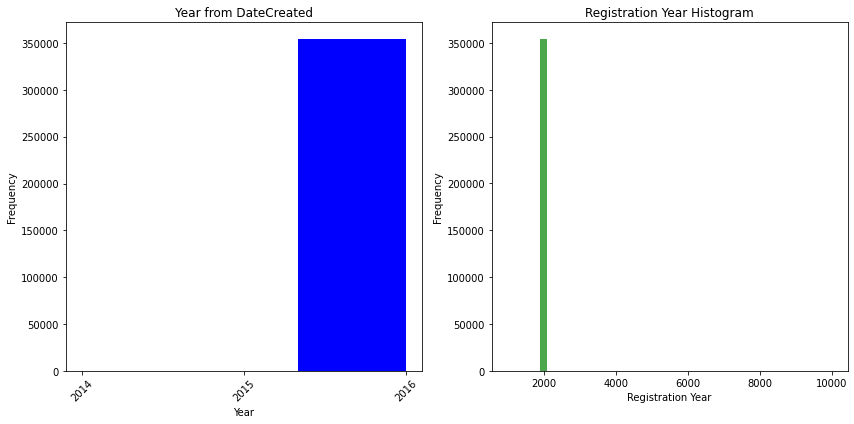

2016    354343
2015        25
2014         1
Name: YearCrawled, dtype: int64
60095
27743


In [9]:
# Проверка данных на адекватность часть 2
df['Year'] = pd.to_datetime(df['DateCreated']).dt.year
print(df['Year'].value_counts())
print(df['RegistrationYear'].value_counts())
# Построим графики для наглядности
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

unique_years = df['Year'].unique()
axs[0].hist(df['Year'], bins=3, color='blue', align='mid')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Year from DateCreated')
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_xticks(unique_years)


axs[1].hist(df['RegistrationYear'], bins=50, color='green', alpha=0.7)
axs[1].set_xlabel('Registration Year')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Registration Year Histogram')

plt.tight_layout()
plt.show()

# Посмотрим когда собирались данные по столбцу DateCrawled
df['YearCrawled'] = pd.to_datetime(df['DateCreated']).dt.year
print(df.YearCrawled.value_counts())
# Думаю для чистоты эксперимента надо выкинуть всё что было собрано не в 2016, 
# там всё равно 26 записей всего.

# Посмотрим сколько данных мы потеряем если удалим авто с ценой = 0, 
# мощностью = 0, мощностью > 500, годом регистрации > 2016 и датой подачи объявления > 2016
print(df.query(
    'Price == 0 or Power == 0 or Power > 500 or RegistrationYear > 2016\
    or Year < 2016 or RegistrationYear < 1980'
).shape[0])
# Посмотрим что будет если убрать из условия мощность
print(df.query(
    'Price == 0 or RegistrationYear > 2016 or Year < 2016 or RegistrationYear < 1980'
).shape[0])
# С этим уже можно жить, к удалению ~27700 записей, а мощность импутируем.

Видно что объявления подавались только в 2016 году, и собирались данные тоже в основном в 2016. Поэтому объявления где дата регистрации авто более 2016 года и меньше 1980 удалим. Также удалим объявления где дата подачи объявления не 2016 год, потому что таких только 26 штук и это подозрительно. Таким образом мы избавляемся от 10% данных. После этого импутируем столбец Power используя метод ближайших соседей.

In [10]:
# Теперь удалим записи с неполными/неверными данными
to_rem_ind = df.query(
    'Price == 0 or RegistrationYear > 2016 or Year < 2016 or RegistrationYear < 1980'
).index
df = df.drop(to_rem_ind)
# Проверим на дубликаты
df[df.duplicated(keep=False)]
# Дубликаты присутствуют, оставим только первые записи
df = df.loc[~df.duplicated(keep='last')]

In [11]:
# Импутация столбца Power
df.loc[df['Power'] > 500, 'Power'] = np.nan
df['Power'].replace(0, np.nan, inplace=True)
features = df.drop(['Power'], axis=1)
target = df['Power']

knn_imputer = KNNImputer(n_neighbors=3)
imputed_power = knn_imputer.fit_transform(target.values.reshape(-1, 1)).ravel()
df['Power'] = imputed_power

Перейдем к удалению лишних столбцов.

In [12]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen',
       'Year', 'YearCrawled'],
      dtype='object')

In [13]:
df = df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'NumberOfPictures', 'LastSeen',
              'Year', 'YearCrawled'], 
             axis=1)

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Здесь отлично. Всё так, эти столбцы (3 даты, индекс и количество фотографий) можно "безболезненно" из нашего датафрейма удалить. Действительно, ведь даты создания, последнего просмотра (активности) и дата скачивания анкеты, а также количество фотографий автомобиля и почтовый индекс владельца анкеты могут повторяться (не уникальны) и бесполезны с точки зрения построения моделей машинного обучения. 

Также я БЫЛ БЫ согласен и с удалением столбца 'registration_month'. Не сильно интересен нам месяц. Достаточно года регистрации (который мы и будем считать временем  выезда автомобиля "на дороги общего пользования").</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Я считаю что можно и оставить, так как декабрьские машины могут быть дороже январских, при прочих равных.</font>
</div>


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Хорошо Айдар, аргументированная позиция достойна и внимания и уважения. Принимаю.
</div>

В последнем выводе df.info() видно что все столбцы стали object, что означает что python считает их за нечисловые или смешанные данные. Попробуем это исправить.

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Осталось несколько ошибок в наших данных:
    
1. есть ли автомобили с ценой == 0? Каков минимальный порог цены?
    
2. есть ли автомобили с мощностью == 0? А с мощностью > 500 л.с.
    
3. каков максимальный год подачи объявлений и встречаются ли объявления с датой подачи более поздней?
    
4. интересуют ли нас раритетные автомобили? Каков год отсечки таких раритетов?
    
5. есть ли в наших данных дубликаты? Нужны ли нам такие "близнецы"?   
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Поменял порядок ячеек, добавил новые. Исправил. </font>
</div>


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Да, отлично, вижу соответствующий код в ячейках 9-11.
    
</div>

На этапе предобоработки данных мы познакомились с данными, удалили лишние столбцы и заполнили пропуски.

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Данные загружены, отлично.

Хорошо, что применяешь метод .head()/.sample() таким образом в память не будет загружен весь датасет, объем которого может быть огромным.

Методы .info, .describe, .value_counts(), .unique() как правило часто встречаются и обязательны к применению в задачах по исследованию данных, ведь с их помощью можно получить первые инсайты. 

Итак, мы провели предварительный анализ данных, проверили данные на наличие пропусков и затем обработали их (аргументированно заполнили / удалили / оставили как есть). Теперь можно приступать собственно к анализу данных и ответам на вопросы проекта.
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Несколько моментов "на будущее" (сейчас забегаю чуть вперед, но будущем это будет важно) которые я хотел озвучить перед переходом к собственно исследованию (некоторые из этих моментов в твоем проекте реализованы):
    
- имеет смысл критично посмотреть на данные с точки зрения наличия пропусков в признаках (вопрос: все ли ml-модели "любят" пропуски?) и обработать или удалить их 
    
- имеет смысл явно обозначить какую задачу мы будем решать: с учителем / без учителя, классификации / регрессии ...
    
- в моделях бинарной классификации (если бы это был бы наш случай!) имеет смысл смотреть на баланс классов. Два взгляда (с разных сторон) на эту проблему тут: https://alexanderdyakonov.wordpress.com/2021/05/27/imbalance/ и https://habr.com/ru/post/349078/
    
- имеет смысл смотреть на корреляцию признаков. При высокой их степени коррелированности возникает проблема  мультиколлиниарность признаков. Проблема "мультиколлинеарности" это и про переобучение модели и про её интерпретируемость и про сложность модели (содержание в модели избыточного количества переменных). В чем негативный эффект сложной модели? Вот в чем: усложняется интерпретация параметров, оценки параметров ненадежны – получаются большие стандартные ошибки, которые меняются с изменением объема наблюдений, что делает модель регрессии непригодной для прогнозирования.

<br>
<br>
<details>
<summary style="color: blue; font-size: 18px; font-weight: bold;">▶ <u>Подробнее ...</u></summary>

Вот несколько причин, почему проблема мультиколлинеарности (МК) важна:

1. Неоднозначность коэффициентов: МК делает оценку коэффициентов модели неустойчивой. Когда существует сильная корреляция между признаками, модель становится неспособной разделить влияние каждого признака на целевую переменную. Это может привести к неоднозначным и неправильным оценкам коэффициентов, что затрудняет интерпретацию важности каждого признака. Согласись - это важно, чтобы результат, который выдает модель можно было бы понять и объяснить с точки зрения предметной области. В случае включения в модель высокоскоррелированных признаков - может случиться так, что коэффициенты (да, проблема присуща моделям линейным ... регрессия среди них!) могут менять знаки и попытка объяснения предметной области с помощью этих коэффициентов будет противоречить здравому смыслу.

2. Плохая обобщающая способность: МК может снизить способность модели обобщаться на новые данные. Когда сильно коррелированные признаки присутствуют в модели, модель может стать "перегенерированной" и склонной к переобучению на обучающих данных. В результате модель может показывать хорошую производительность на обучающих данных, но плохо обобщаться на новые данные.

3. Ухудшение точности и устойчивости модели: МК может привести к численным проблемам при решении линейных уравнений, используемых для оценки коэффициентов модели. Это может привести к нестабильности и неточности оценок. Кроме того, небольшие изменения в данных могут привести к большим изменениям в оценках коэффициентов модели, что делает модель неустойчивой.

4. Избыточность информации: Когда признаки сильно коррелированы, они предоставляют практически одинаковую информацию о целевой переменной. Такая избыточность может привести к неэффективности модели и увеличению сложности модели без значительного улучшения производительности.

В целом, МК может иметь отрицательное влияние на производительность, стабильность, интерпретируемость и обобщающую способность.
    
---
Для деревянных моделей и моделей градиентного бустинга проблема МК  не является такой критической, как для линейных моделей. Вот несколько причин:

1. Нелинейность: Деревянные модели и модели градиентного бустинга являются нелинейными моделями. Они способны обрабатывать сложные взаимодействия между признаками и целевой переменной. В отличие от линейных моделей, они могут более гибко адаптироваться к наличию мультиколлинеарности в данных.

2. Рекурсивное разбиение: Деревья принятия решений в деревянных моделях и моделях градиентного бустинга используют рекурсивное разбиение для разделения данных на более чистые группы. Это означает, что деревья могут независимо выбирать разные признаки для разделения, даже если они сильно коррелированы. Таким образом, деревья могут игнорировать мультиколлинеарность и использовать другие признаки для принятия решений.

3. Ансамбль деревьев: Модели градиентного бустинга строятся на основе ансамбля слабых деревьев решений. Каждое дерево добавляется постепенно для уменьшения ошибки предыдущих деревьев. Это позволяет модели градиентного бустинга восстанавливать ошибки, вызванные мультиколлинеарностью, поэтапно улучшая прогнозы.

Хотя мультиколлинеарность не является проблемой в деревянных моделях и моделях градиентного бустинга в той же степени, что и в линейных моделях, она все еще может оказывать влияние на производительность и интерпретируемость модели. Сильно коррелированные признаки могут вносить избыточность в модель и увеличивать сложность, не принося значительного улучшения в прогнозах. Поэтому, хотя деревья могут быть более устойчивыми к мультиколлинеарности, все же рекомендуется выполнять анализ корреляции признаков и, при необходимости, применять методы снижения размерности или регуляризации для улучшения модели.
    
Вот классная статья. Простым языком, на примере показана проблема. А также, что важно - разобраны варианты как её (проблему) победить. Статья: https://habr.com/ru/company/akbarsdigital/blog/592493/ 
    
</details>
<br>
<br>    
</div>

## Обучение моделей

Подготовим данные для обучения моделей. Столбцы с категориальным переменными необходимо закодировать с помощью фиктивных переменных.

In [14]:
# Подготовка данных
X = df.drop('Price', axis=1)
y = df['Price']

all_cols = X.columns

# Создадим список столбцов которые надо закодировать
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Трансформатор для столбцов, поскольку нам надо проверить модель случайного леса, а она не терпит категориальных значений.
preprocessor_cols = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', ce.BinaryEncoder(), categorical_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessor_cols.fit_transform(X_train)
X_test = preprocessor_cols.transform(X_test)

print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0])

261297 65325 261297 65325


<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

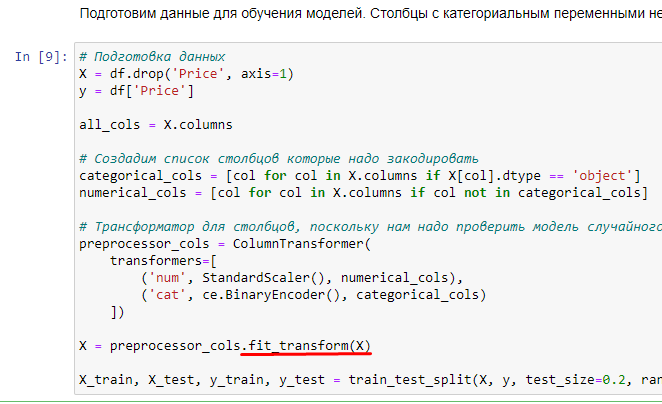    
    
Айрат, мне кажется у тебя тут утечка данных из теста в трейн происходит.
    
---    
При обучении моделей машинного обучения очень важно соблюдать правило неиспользования информации из тестового набора в процессе обучения модели. Это называется "принципом честности по отношению к данным" (data fairness principle) или "правилом изоляции тестового набора" (holdout rule).

Когда мы применяем кодирование целевой переменной, мы используем информацию о целевой переменной для создания новых признаков на основе категориальных переменных. Если мы включим информацию из тестового набора (например, при вычислении среднего значения целевой переменной), мы нарушим правило честности по отношению к данным.

Обучение энкодера на тренировочном наборе позволяет использовать информацию только из него (для создания закодированных признаков). Это важно для создания модели, которая будет обобщать и хорошо работать на новых, ранее не встречавшихся данных. При использовании всего набора данных для обучения мы нарушаем разделение между тренировочным и тестовым наборами, что может привести к переобучению и недостаточной обобщающей способности модели.

<br>
<br>
<details>
<summary style="color: blue; font-size: 18px; font-weight: bold;">▶ <u>Подробнее ...</u></summary>

Итак, кодировать данные (используя BinaryEncoder (а также OneHotEncoder и OrdinalEncoder и LabelEncoder и MEstimateEncoder)) следует ПОСЛЕ разбиения данных на выборки. Если кодирование (и/или масштабирование) выполняются до разбиения данных на выборки, то информация из тестовой выборки может просочиться в обучающую выборку. Это может привести к переобучению модели и неверным результатам.

p.s. Дальше - на примере OneHotEncoder. Нет, конечно OneHotEncoder можно применять и до разбиения на выборки. Однако, если ты собираешься применять OHЕ до разбиения на выборки, то нужно обязательно использовать только те значения (строки), которые был представлены в обучающей выборке (а это усложнит код - нужно отбирать соответствующие строки используя индексы). Если же использовать значения из всего набора данных, то повторюсь - это может привести к переобучению моделей (ввиду утечки данных).
    
Итак, для кодирования данных в выборках с помощью OneHotEncoder из scikit-learn нужно выполнить следующие шаги:

1. Импортировать класс OneHotEncoder из модуля sklearn.preprocessing.

2. Создать объект OneHotEncoder с нужными параметрами, например, sparse=False, если хотим получить "плотный" массив вместо разреженной матрицы. Не забыть про drop='first' (возможно!).
    
3. Вызвать метод fit на объекте OneHotEncoder, передав ему обучающую выборку с категориальными признаками. Это позволит ему определить уникальные значения для каждого признака и создать соответствующие бинарные столбцы.
    
4. Вызвать метод transform на объекте OneHotEncoder, передав ему тестовую выборку с категориальными признаками. Это позволит ему преобразовать категориальные значения в бинарные столбцы, используя те же коды, что и для обучающей выборки.
    
5. Объединить полученный массив с остальными числовыми признаками, например используя функцию numpy.concatenate или метод pandas.DataFrame.join.    
    
Почему нельзя кодировать сразу и тестовую и обучающую выборки? Потому что это может привести к утечке данных. Если мы кодируем сразу и тестовую и обучающую выборки, то таким образом в кодирование включается информация о категориях, которые не встречаются в обучающей выборке, но есть в тестовой. Это может дать модели преимущество при предсказании на тестовых данных, которое не отражает ее реальную способность обобщать на новых данных. Чтобы избежать этого, мы должны кодировать данные только на основе обучающей выборки и применять тот же энкодер к тестовой выборке.

p.s. и ещё, мне коллеги-студенты одной из когорт прислали то, как их преподаватель объясняет этот момент (возможно будет полезно): **Вообще в предобработке для машинного обучения нужно соблюдать такой порядок: Сначала разбиваем на обучающую и тестовую (ещё валидационную, если кросс-валидацию не используем) выборки, а потом уже пропуски заменяем, колируем, масштабируем. При этом энкодеры и скейлеры обучаем только на трейне. Для теста и валидационной выборки применяем transform только без fit.**

---
**И ещё: главный принцип: из теста данные не должны в трейн попадать. Тестовая выборка симулирует данные получаемые моделью во время работы. Поэтому нужно все манипуляции проводить после разбиения на выборки. Второй аспект: т.к. тестовая выборка симулирует работу модели в реальных условиях, когда у нас по сути выборки нет и мы должны для любой отдельной новой записи делать предсказание, то заполнение пропусков, масштабирование, кодирование делаем на основе данных из обучающей выборки: т.е. энкодеры, скейлеры импутеры обучаем на трейне, а на тесте применяем tranform."**

А теперь небольшое продолжение, но уже применительно к OrdinalEncoder(). На самом деле всё тоже самое, но тем не менее ....

Кодирование категориальных признаков следует делать после разделения данных на выборки. Это связано с тем, что кодирование может вносить информацию из обучающей выборки в тестовую выборку, что приводит к переобучению и неправильной оценке модели. Например, если мы используем OrdinalEncoder() с параметром categories=‘auto’, то он будет определять уникальные значения категориальных признаков на основе всего набора данных. Это значит, что мы будем использовать информацию из тестовой выборки для кодирования обучающей выборки, что нарушает принцип независимости данных.

Чтобы избежать этой проблемы, мы должны сначала разделить данные на обучающую и тестовую выборки, а затем применять OrdinalEncoder() к каждой выборке отдельно. При этом мы должны использовать метод fit_transform() для обучающей выборки и метод transform() для тестовой выборки, например:

    from sklearn.preprocessing import OrdinalEncoder
    from sklearn.model_selection import train_test_split

    # разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # создаем объект OrdinalEncoder
    encoder = OrdinalEncoder()

    # применяем OrdinalEncoder к обучающей выборке
    X_train_encoded = encoder.fit_transform(X_train)
    
    # применяем OrdinalEncoder к тестовой выборке
    X_test_encoded = encoder.transform(X_test)

</details>
<br>
<br>
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Исправил</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Да, вижу, что ColumnTransformer учится на трейне и потом трансформирует и трейн и тест.
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

1. Здесь хорошо, происходит фиксация random_state. Воспроизводимость результатов разбиения выборки на обучающую (тренировочную) и тестовую мы обеспечили, значит при всех последующих запусках нашего кода подвыборки будут идентичными.
    
2. Доли размеров train/test как 4:1 - хорошо.
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Я бы рекомендовал после разбиения данных на выборки посмотреть на их **размеры и размерности**. Метод shape для этого - идеальный помощник. "Цифры" по выборкам покажут верно ли мы произвели "разделение" данных.

p.s. так (**псевдокод**): X_train.shape[0] – «покажет» количество строк в тренировочной выборке, а X_train.shape[1] - количество столбцов в ней же. Ну а X_train.shape – выведет размерность train'а в виде кортежа с 2мя значениями (первое число – количество строк, второе – столбцов).</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Добавил вывод shape[0].</font>
</div>


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Отлично, спасибо!
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Исключительно как вариант, а также воспользоваться советом со Стэковерфлоу: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213

	train, valid, test = np.split(df.sample(frac=1, random_state=821), [int(.6*len(df)), int(.8*len(df))])

Также, разбивать данные можно и автоматизировано, используя библиотеку fast_ml (см. скрин). К этому скрину один комментарий – не факт, что эта библиотека fast_ml развернута здесь, на Хабе, НО дома, своей локальной машине, с установленной средой (например Анакондой: https://www.anaconda.com/products/distribution) ты вполне можешь этим вариантом пользоваться (после установки **!pip install fast_ml**):
</div>

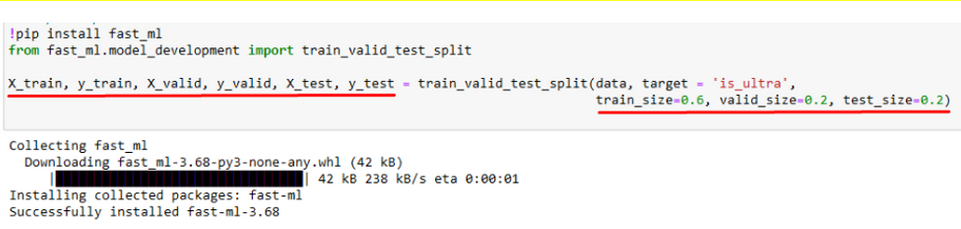

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Учту на будущее.</font>
</div>


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Это просто как вариант, Айдар.
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Отлично, 5 шагов (EDA, обработка аномалий и пропусков, разделение данных на выборки, масштабирование/нормировку и кодирование признаков), входящие в типичный пайплайн подготовки данных **к этому моменту должны быть выполнены** ...

Я тебе совет дам: создай шаблон кода (или функцию/функции), которые будут работать с момента загрузки данных и до получения выборок, готовых к передаче в модели МО.
    
Зачем такой шаблон нужен? Чтобы не ломать всякий раз голову, не вспоминать и писать руками один и тот же код (да ещё и с возможностью совершить "глупую" ошибку). В шаблоне должны быть (как минимум) следующие рутинные процедуры, которые встречаются ну абсолютно в каждом МО-проекте:
    
1. разбиение данных на выборки,

2. масштабирование/нормировка.    

3. обработка категориальных признаков,
    
Затем ты этот шаблон будешь вставлять в каждый новый проект, чуть модифицировать его (имена переменных, названия столбцов) и гарантированно получать работающий и безошибочный код.
    
А ресурсы головы ))) лучше тратить на подбор гиперпараметров и генерацию новых фичей - вот здесь находится то, что способно выделить твои модели, поднять их качество.    
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Присмотрись к использованию трансформеров и пайплайнов в машинном обучении. Да, это расширенный и поначалу сложный и непонятный концепт, НО ... вот их преимущества при использовании в коде:

Преимущества использования трансформеров:

1. **Гибкость и модульность**: Трансформеры позволяют разбить сложные операции по предобработке данных на более мелкие и легко управляемые компоненты. Это делает код более читаемым и модульным.

2. **Переиспользование**: Трансформеры могут быть повторно использованы на разных этапах анализа данных и построения моделей. Например, ты можешь создать трансформер для нормализации данных и использовать его как в обучении модели, так и на этапе инференса.

3. **Работа с разными типами данных**: Трансформеры могут обрабатывать различные типы данных, включая текст, изображения и числовые значения. Это позволяет тебе создавать единые интерфейсы для предобработки разнообразных данных.

Преимущества использования пайплайнов:

1. **Структурированность**: Пайплайны помогают организовать последовательность шагов обработки данных, начиная с загрузки и заканчивая подготовкой к обучению модели. Это обеспечивает структурированность и позволяет легко вносить изменения.

2. **Поддержание кода**: Пайплайны сокращают вероятность ошибок и упрощают поддержание кода. Отслеживание последовательности операций делает процесс отладки и оптимизации более прозрачным.

3. **Масштабируемость**: Пайплайны могут быть легко расширены новыми этапами обработки данных. Это позволяет добавлять новые операции без переписывания всего кода.

Объединение трансформеров и пайплайнов позволяет создавать чистые, структурированные и гибкие рабочие процессы для подготовки данных. Например, ты можешь создать трансформеры для преобразования текстовых данных и числовых значений, а затем построить пайплайн, который последовательно применяет эти трансформеры и завершается обучением модели. Это существенно упростит управление и анализ данных перед обучением моделей машинного обучения.

Несколько ссылок, которые позволят погрузиться в тему:

- [трансформеры](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) и [пайплайны](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) для организации предобработки (кодирования, масштабирования) и модели
- применение пайплайна [A Basic Introduction to Pipelines in Scikit Learn](https://towardsdatascience.com/a-basic-introduction-to-pipelines-in-scikit-learn-bd4cee34ad95)
- большой гайд как можно комбинировать разные этапы предобработки [Pipelines and composite estimators](https://scikit-learn.org/stable/modules/compose.html)
- или можно написать свой класс-трансформер [Custom Transformers and Pipelines in Python](https://towardsdatascience.com/custom-transformers-in-python-part-ii-6fe111fc82e4)
</div>

Приступим к тренировке моделей.

In [16]:
# Набор гиперпараметров
lgb_params = {
    'n_estimators': [150, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'random_state': [42]
}

# Инициализация модели
lgb_model = lgb.LGBMRegressor()

# Инициализуем GridSearchCV
grid = GridSearchCV(lgb_model, lgb_params, cv=5, scoring='neg_root_mean_squared_error')

# Нахождение лучших параметров
start_time = time.time()
grid.fit(X_train, y_train)
lgb_learning_time = time.time() - start_time

# Вытаскиваем лучший набор параметров
best_params = grid.best_params_

# Тренируем модель на лучших параметрах
start_time = time.time()
lgb_model = lgb.LGBMRegressor(**best_params)
lgb_model.fit(X_train, y_train)
lgb_learning_time_2 = time.time() - start_time

# Делаем предсказание и рассчитываем RMSE
start_time = time.time()
lgb_predictions = lgb_model.predict(X_test)
lgb_prediction_time = time.time() - start_time
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))

# Статистика для модели LightGBM
print('LightGBM Model:')
print(f'Best Parameters: {best_params}')
print(f'Best Parameters Finding Time: {lgb_learning_time:.6f} seconds')
print(f'Root Mean Squared Error (RMSE): {lgb_rmse:.4f}')
print(f'Learning Time: {lgb_learning_time_2:.6f} seconds')
print(f'Prediction Time: {lgb_prediction_time:.6f} seconds')


LightGBM Model:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 42}
Best Parameters Finding Time: 350.018268 seconds
Root Mean Squared Error (RMSE): 2467.5312
Learning Time: 18.508692 seconds
Prediction Time: 0.903693 seconds


<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Почему разбиваешь данные только на 2 выборки (и при этом не используешь кросс-валидацию)? 

**ВОПРОСЫ:** Для чего в проектах МО используются тренировочная, валидационная и тестовая выборки (в смысле каковы их роли)? Как (на какой выборке) ты будешь проверять модели после подбора гиперпараметров (ГП)?

**ОТВЕТЫ:** Кросс-валидацию ты не используешь, поэтому нужно данные разбивать на 3 выборки. На тренировочной  - учить модель, гиперпараметры и оценку степени переобученности выполнять на валидцаии. Финальную оценку качества моделей выполнять на тестовой выборке.

p.s. этот момент надо исправить и ниже, во всех разделах, у всех моделей.
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Добавил кросс валидацию и подбор лучших параметров в одной функции GridSearchCV, двух зайцев одним выстрелом как говорится.</font>
</div>


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Есть, отлично!
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> Почему-то на сервере Яндекса LightGBM рассчитывается очень долго, у меня локально он отбегает в 2 раза быстрее CatBoostа, а здесь 164 секунды.

<b>Комментарий студента</b>


<div class="alert alert-warning">
<b>Комментарий 👉</b>

Айрат, потому что ресурсы локального компьютера принадлежат только тебе, а ресурсы серверов Яндекса "деляться" на примерно 200 ревьюеров и несколько тысяч студентов (в пиковых нагрузках действительно скрость ниже чем на РС).
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Ну всё равно странно, катбуст то локально медленнее в 2 раза, а здесь наоборот получается. По моей логике и на сервере должно быть так же, потому что у меня локально как и на сервере линукс.</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Если вопрос остается, то можешь в техподдержку Я. написать, но думаю плюс/минус ответ будет связан с периодической загрузкой серверных мощностей.
</div>

In [19]:
# Набор гиперпараметров
cat_params = {
    'iterations': [150, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [5, 7],
    'random_state': [42]
}

# Инициализация модели
cat_model = cb.CatBoostRegressor(verbose=0)

# Инициализуем GridSearchCV
grid = GridSearchCV(cat_model, cat_params, cv=5, scoring='neg_root_mean_squared_error')

# Нахождение лучших параметров
start_time = time.time()
grid.fit(X_train, y_train)
cat_learning_time = time.time() - start_time

# Вытаскиваем лучший набор параметров
best_params = grid.best_params_

# Тренируем модель на лучших параметрах
start_time = time.time()
cat_model = cb.CatBoostRegressor(**best_params)
cat_model.fit(X_train, y_train)
cat_learning_time_2 = time.time() - start_time

# Делаем предсказание и рассчитываем RMSE
start_time = time.time()
cat_predictions = cat_model.predict(X_test)
cat_prediction_time = time.time() - start_time
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_predictions))

# Статистика для модели CatBoost
print('CatBoost Model:')
print(f'Best Parameters: {best_params}')
print(f'Best Parameters Finding Time: {cat_learning_time:.6f} seconds')
print(f'Root Mean Squared Error (RMSE): {cat_rmse:.4f}')
print(f'Learning Time: {cat_learning_time_2:.6f} seconds')
print(f'Prediction Time: {cat_prediction_time:.6f} seconds')

0:	learn: 4226.7880495	total: 44ms	remaining: 8.76s
1:	learn: 3959.9070222	total: 82.1ms	remaining: 8.13s
2:	learn: 3718.7649762	total: 122ms	remaining: 8.01s
3:	learn: 3509.8288748	total: 162ms	remaining: 7.94s
4:	learn: 3328.2309882	total: 203ms	remaining: 7.9s
5:	learn: 3165.4269741	total: 242ms	remaining: 7.83s
6:	learn: 3022.3376757	total: 283ms	remaining: 7.8s
7:	learn: 2897.1180141	total: 322ms	remaining: 7.72s
8:	learn: 2790.5769651	total: 358ms	remaining: 7.6s
9:	learn: 2693.6676577	total: 396ms	remaining: 7.53s
10:	learn: 2609.0606601	total: 433ms	remaining: 7.44s
11:	learn: 2535.6764221	total: 477ms	remaining: 7.47s
12:	learn: 2474.3444025	total: 514ms	remaining: 7.39s
13:	learn: 2419.0586249	total: 550ms	remaining: 7.31s
14:	learn: 2367.6706760	total: 588ms	remaining: 7.25s
15:	learn: 2325.7417475	total: 625ms	remaining: 7.18s
16:	learn: 2282.5415403	total: 662ms	remaining: 7.13s
17:	learn: 2249.4886885	total: 700ms	remaining: 7.07s
18:	learn: 2220.7030869	total: 737ms	rema

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Метрика RMSE высока что для Катбуста, что для ЛайтГБМ потому, что в lgb_params/cb_params у тебя фиксированные значения, а не диапазоны значений (из которых или в цикле или крос-валидацией будут выбираться лучшие гиперпараметры).
</div>

In [20]:
# Набор гиперпараметров
rf_params = {
    'n_estimators': [50, 70],
    'max_depth': [5, 7],
    'random_state': [42]
}

# Инициализация модели
rf_model = RandomForestRegressor()

# Инициализуем GridSearchCV
grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_root_mean_squared_error')

# Нахождение лучших параметров
start_time = time.time()
grid.fit(X_train, y_train)
rf_learning_time = time.time() - start_time

# Вытаскиваем лучший набор параметров
best_params = grid.best_params_

# Тренируем модель на лучших параметрах
start_time = time.time()
rf_model = RandomForestRegressor(**best_params)
rf_model.fit(X_train, y_train)
rf_learning_time_2 = time.time() - start_time

# Делаем предсказание и рассчитываем RMSE
start_time = time.time()
rf_predictions = rf_model.predict(X_test)
rf_prediction_time = time.time() - start_time
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

# Статистика для модели Random Forest
print('Random Forest Model:')
print(f'Best Parameters: {best_params}')
print(f'Best Parameters Finding Time: {rf_learning_time:.6f} seconds')
print(f'Root Mean Squared Error (RMSE): {rf_rmse:.4f}')
print(f'Learning Time: {rf_learning_time_2:.6f} seconds')
print(f'Prediction Time: {rf_prediction_time:.6f} seconds')

Random Forest Model:
Best Parameters: {'max_depth': 7, 'n_estimators': 70, 'random_state': 42}
Best Parameters Finding Time: 501.555043 seconds
Root Mean Squared Error (RMSE): 2416.1114
Learning Time: 32.944939 seconds
Prediction Time: 0.231235 seconds


## Анализ моделей

LightGBM Model:
- Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 42}
- Best Parameters Finding Time: 350.018268 seconds
- Root Mean Squared Error (RMSE): 2467.5312
- Learning Time: 18.508692 seconds
- Prediction Time: 0.903693 seconds

CatBoost Model:
- Best Parameters: {'depth': 7, 'iterations': 200, 'learning_rate': 0.1, 'random_state': 42}
- Best Parameters Finding Time: 303.729954 seconds
- Root Mean Squared Error (RMSE): 2559.9517
- Learning Time: 8.655317 seconds
- Prediction Time: 0.020525 seconds

RandomForest Model:
- Best Parameters: {'max_depth': 7, 'n_estimators': 70, 'random_state': 42}
- Best Parameters Finding Time: 501.555043 seconds
- Root Mean Squared Error (RMSE): 2416.1114
- Learning Time: 32.944939 seconds
- Prediction Time: 0.231235 seconds

__Вывод__:
Имея вводные, что заказчику важны качество предсказания скорость предсказания и время обучения я бы посоветовал выбрать модель на основе RandomForest, так как у неё самое точное предсказание, скорость предсказания на втором месте, c минимальным отрывом от модели CatBoost, но последняя не прошла по RMSE. Если в приоритете время обучения то стоит выбрать модель LightGBM, однако время предсказания в 4 раза выше в сравнении с моделью RandomForest.

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Всё отлично, результат достигнут. 

Требованиям ТЗ твой проект устраивает. 

Во первых, для интересующей Заказчика метрики (RMSE) её порог (менее 2500) - достигнут. 

Во-вторых, оценки времени работы моделей являются реалистичными и позволят использовать модели в проде, на оборудовании Заказчика с требуемой производительноостью. 

</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей

# Результат ревью:

Я отмечаю адекватный уровень твоей программистской подготовки. Ты используешь продвинутые концепции языка Python, библиотеки pandas и одной из основных библиотек машинного обучения sckit-learn. Всё это в целом упрощает твой код и одновременно показывает твой уровень владения инструментами анализа данных и machine learning.

С комментированием никаких проблем нет. Твоих объяснений достаточно для понимания твоими коллегами хода мыслей. Ссылки из брифа проекта в нужных местах также помогают следовать за развитием событий и дают полную информацию касаемо того, что будет происходить в том или ином разделе проекта.

Мне было просто проверять твой проект, потому что он чётко структурирован, с использованием оглавления. 

Зелёным цветом я отметил и прокомментировал удачные и элегантные решения, на которые ты можешь опираться в будущих проектах.

Жёлтым цветом я выделил то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас.

Однако есть принципиальные моменты, которые не позволяют мне принять твой проект в его нынешнем состоянии:

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b> 

1. Осталось несколько ошибок в наших данных: 1. есть ли автомобили с ценой == 0? Каков минимальный порог цены? 
2. есть ли автомобили с мощностью == 0? А с мощностью > 500 л.с. 3. каков максимальный год подачи объявлений и встречаются ли объявления с датой подачи более поздней? 4. интересуют ли нас раритетные автомобили? Каков год отсечки таких раритетов? 5. есть ли в наших данных дубликаты? Нужны ли нам такие "близнецы"?   

2. Кодировать данные следует ПОСЛЕ разбиения данных на выборки. Если кодирование (и/или масштабирование) выполняются до разбиения данных на выборки, то информация из тестовой выборки может просочиться в обучающую выборку. Это может привести к переобучению модели и неверным результатам.

3. Почему разбиваешь данные только на 2 выборки (и при этом не используешь кросс-валидацию)? 

</div>

Эти 3 момента требуют твоего внимания. Комментарии по ним помечены красным цветом. 

Подводя итог: хорошая работа на самом-то деле, молодец! Есть несколько моментов к исправлению, но уверен, что они не вызовут у тебя сложностей. После доработки обязательно проверь комментарии и выводы. Их нужно будет скорректировать. Жду доработанную версию проекта на повторное ревью.


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Внес правки с учетом замечаний.</font>
</div>


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>

Айдар, был рад помочь! Был рад работать с тобой совместно над проектом! У меня вопросов больше нет, проект принимаю!
</div>